In [1]:
#loading necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN
from scipy import stats
from sklearn.metrics import r2_score
%matplotlib inline

Using TensorFlow backend.


In [3]:
#loading data
cab_train = pd.read_csv('train_cab.csv')
cab_test = pd.read_csv('test.csv')

## Understanding the data and Exploratory Data Analysis
To know the basic understanding of the dataset such as shape, data types, uniques values, missing value analysis, to understand the basic statistics of each variable and all the pre-processing techniques.

In [4]:
#Shape of the data
print(cab_train.shape) #(16067,7)
print(cab_test.shape) #(9914,6)

(16067, 7)
(9914, 6)


In [5]:
#First five rows of our train data
cab_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [6]:
#First five rows of our test data
cab_test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [7]:
#Number of Unique values in train data
cab_train.nunique()

fare_amount            468
pickup_datetime      16021
pickup_longitude     13789
pickup_latitude      14241
dropoff_longitude    13887
dropoff_latitude     14263
passenger_count         27
dtype: int64

In [8]:
#To find the missing values in our dataset
cab_train.isna().sum()

fare_amount          24
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [9]:
#To know the data types in train dataset
cab_train.dtypes

#Fare_amount should be float
#pickup_datetime should be a date type
#passenger_count should be an integer type

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [10]:
#To know the data types in test dataset
cab_test.dtypes

#pickup_datetime should be a date type

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

A few observations from the datasets
   * `pickup_datetime` should be converted to date type using pandas
   * `passenger_count` should be an int type and any data point less than 1 and greater than 6 can be removed/imputed
   * `fare_amount` should be a float type and any data point less than 0 can be removed/imputed
   * `pickup_latitude` and `dropoff_latitude` should have values in between -90 to +90 degrees and data point beyond these     values can be removed
   * `pickup_longitude` and `dropoff_longitude` should have values in between -180 to +180 degrees and data point beyond these     values can be removed
   * By using the co-ordinates of latitude and longitude, we can find the distance between pickup and drop locations
   * After the above steps, we'll try to drop a few variables and data types are to properly converted

In [11]:
#Convert the data types
cab_train['fare_amount'] = pd.to_numeric(cab_train['fare_amount'] , errors = 'coerce')
#By using errors parameter with corece value, we can replace non-numeric values with NaN values

To convert the `pickup_datetime` to datetime format and to separate year,month and date etc.
While trying to convert `pickup_datetime` it was found that value at index# 1327 is 43, which is to be dropped.

In [12]:
np.where(cab_train['pickup_datetime'] == '43')
cab_train.iloc[1327,:]
cab_train = cab_train.drop(cab_train.index[1327])

In [13]:
#To convert the pickup_datetime to datetime format and separating year,month and date etc.
cab_train['pickup_datetime'] = pd.to_datetime(cab_train['pickup_datetime'], format = "%Y-%m-%d %H:%M:%S UTC")

In [14]:
#To check the data types
cab_train.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
dtype: object

In [15]:
#Creating new features such as year, month, date etc. based on the timestamp 
cab_train['year'] = cab_train['pickup_datetime'].dt.year
cab_train['Month'] = cab_train['pickup_datetime'].dt.month
cab_train['Date'] = cab_train['pickup_datetime'].dt.day
cab_train['Day'] = cab_train['pickup_datetime'].dt.dayofweek
cab_train['Hour'] = cab_train['pickup_datetime'].dt.hour

In [16]:
#To check top 5 rows of the data
cab_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Date,Day,Hour
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,0,17
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7


In [17]:
#To convert the pickup_datetime for test data to datetime format and separating year,month and date etc.
cab_test['pickup_datetime'] = pd.to_datetime(cab_test['pickup_datetime'], format = "%Y-%m-%d %H:%M:%S UTC")

In [18]:
#Creating new features such as year, month and date etc based on datetime for test data
cab_test['year'] = cab_test['pickup_datetime'].dt.year
cab_test['Month'] = cab_test['pickup_datetime'].dt.month
cab_test['Date'] = cab_test['pickup_datetime'].dt.day
cab_test['Day'] = cab_test['pickup_datetime'].dt.dayofweek
cab_test['Hour'] = cab_test['pickup_datetime'].dt.hour

* As of now `pickup_datetime` in `cab_train` dataset is cleaned and now let's check with the `passenger_count`
* Any data point with values < 1 and > 6 in `passenger_count` are to be removed

In [19]:
#Let's remove the values in passenger_count variable with the values < 1 and > 6
cab_train = cab_train.drop(cab_train[cab_train['passenger_count'] < 1].index , axis = 0)
cab_train = cab_train.drop(cab_train[cab_train['passenger_count'] > 6].index , axis = 0)

In [20]:
#To check if any missing values in passenger_count and delete them if they are less in number(55 we found)
cab_train['passenger_count'].isnull().sum()
#To remove missing values or null values from passenger_count variable
cab_train = cab_train.drop(cab_train[cab_train['passenger_count'].isnull()].index , axis = 0)
cab_train['passenger_count'].isnull().sum()

0

In [21]:
#Let's remove the values in passenger_count variable with the values < 1 and > 6 in test data also and found no null values
cab_test = cab_test.drop(cab_test[cab_test['passenger_count'] < 1].index , axis = 0)
cab_test = cab_test.drop(cab_test[cab_test['passenger_count'] > 6].index , axis = 0)

In [22]:
#Let's check for the fair_amount variable and any negative values should be removed/imputed
cab_train = cab_train.drop(cab_train[cab_train['fare_amount'] < 0].index, axis = 0)

In [23]:
#We found that we have 24 missing values in fare_amount variable. As this is a less number, we can remove them
cab_train.isnull().sum()
cab_train = cab_train.drop(cab_train[cab_train['fare_amount'].isnull()].index, axis = 0)

By using the the four variables, `pickup_longitude`, `pickup_latitude`,	`dropoff_longitude`, `dropoff_latitude` let's try to find the distance travelled. The usual procedure is to find with Haversine's formula, but let us try with different methods.

In [24]:
# We have found one value in pickup_latitude > 90, (401...) so let's drop that observation

cab_train = cab_train.drop(cab_train[cab_train['pickup_latitude'] > 90].index, axis = 0)

In [25]:
#To find the distance travelled using latitudes and longitudes
from geopy.distance import geodesic

def distance_conversion(x):
    origin_lat = x[0]
    origin_long = x[1]
    dest_lat = x[2]
    dest_long = x[3]
    origin = [origin_lat,origin_long]
    dest = [dest_lat,dest_long]
    distance = geodesic(origin, dest).kilometers
    return distance

#distance_conversion(40.721319,-73.844311,40.712278,-73.841610)
#distance_conversion(40.711303,-74.016048,40.782004,-73.979268)

#Let's create a variable "distance_travelled" and try to find it's values using the above function in both the datasets

cab_train['distance_travelled'] = cab_train[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].apply(distance_conversion,axis=1)
cab_test['distance_travelled'] = cab_test[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].apply(distance_conversion,axis=1)

In [26]:
#To check a few observations after removing the variables
cab_train.head()
cab_test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Date,Day,Hour,distance_travelled
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.320991
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.423802
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,5,11,0.618182
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,5,21,1.959671
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,5,21,5.382833


In [27]:
#To check the variable distance_travelled whose values are zero and found that 454 observations have value as 0
#This will list out the indexes with distance_travelled = 0
#cab_train[cab_train['distance_travelled'] == 0].index

#Let's replace zeros with NAN values and try to impute them
cab_train.loc[cab_train['distance_travelled'] == 0,'distance_travelled'] = np.nan
cab_test.loc[cab_test['distance_travelled'] == 0,'distance_travelled'] = np.nan
cab_train.isna().sum().sum()

454

Let us drop a few variables for which we don't need them as the necessary information from those variables has been extracted

In [28]:
#Dropping the 5 variables as mentioned above
var_to_drop = ['pickup_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude']
cab_train = cab_train.drop(var_to_drop, axis = 1)
cab_test = cab_test.drop(var_to_drop, axis = 1)

In [29]:
#Let's convert a few variables to the required data types in both train and test data
cab_train['passenger_count'] = cab_train['passenger_count'].astype('int64')
cab_train['Month'] = cab_train['Month'].astype('category')
cab_train['Day'] = cab_train['Day'].astype('category')

#Convert in test data
cab_test['Month'] = cab_test['Month'].astype('category')
cab_test['Day'] = cab_test['Day'].astype('category')

In [30]:
#Imputing the missing values
#Actual value = 5.037
#Mean Value = 15.12
#Median Value = 2.196
#KNN value = 4.790
#cab_data['distance_travelled'].iloc[52] = np.nan
#cab_data['distance_travelled'].iloc[52] = cab_data['distance_travelled'].mean()
#cab_data['distance_travelled'].iloc[52] = cab_data['distance_travelled'].median()

#Imputing with KNN method
cab_train = pd.DataFrame(KNN(k = 3).fit_transform(cab_train), columns = cab_train.columns)
cab_test = pd.DataFrame(KNN(k = 3).fit_transform(cab_test), columns = cab_test.columns)

Imputing row 1/15905 with 0 missing, elapsed time: 79.311
Imputing row 101/15905 with 0 missing, elapsed time: 79.313
Imputing row 201/15905 with 0 missing, elapsed time: 79.314
Imputing row 301/15905 with 0 missing, elapsed time: 79.316
Imputing row 401/15905 with 0 missing, elapsed time: 79.319
Imputing row 501/15905 with 0 missing, elapsed time: 79.320
Imputing row 601/15905 with 0 missing, elapsed time: 79.322
Imputing row 701/15905 with 0 missing, elapsed time: 79.324
Imputing row 801/15905 with 0 missing, elapsed time: 79.326
Imputing row 901/15905 with 0 missing, elapsed time: 79.328
Imputing row 1001/15905 with 0 missing, elapsed time: 79.330
Imputing row 1101/15905 with 0 missing, elapsed time: 79.332
Imputing row 1201/15905 with 1 missing, elapsed time: 79.333
Imputing row 1301/15905 with 0 missing, elapsed time: 79.336
Imputing row 1401/15905 with 0 missing, elapsed time: 79.338
Imputing row 1501/15905 with 0 missing, elapsed time: 79.340
Imputing row 1601/15905 with 0 missi

In [31]:
#To verify if we have any null values after KNN imputation
print(cab_train.isnull().sum().sum())
print(cab_train.shape)

0
(15905, 8)


In [32]:
cab_train.dtypes

#Dividing categorical and continuous variables

cont_var = ['passenger_count','year','Date','Hour','fare_amount','distance_travelled']
cat_var = ['Month','Day']

#To take a copy of cab_train dataset
cab_data = cab_train.copy()

Now our `cab_train` dataset is a cleaned one with no missing values. Let's take a copy of `cab_train` as `cab_data` with dimensions (15905,8) and let's work on it for further steps.

## Univariate and Bivariate Analysis
* Let us visualize the distribution of variables in our train dataset
* We will use histograms for continuous variables and barplots for the categorical variables

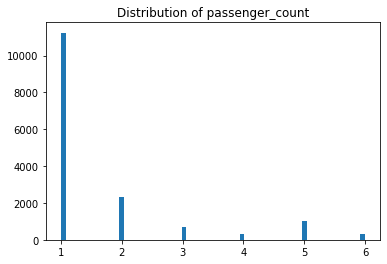

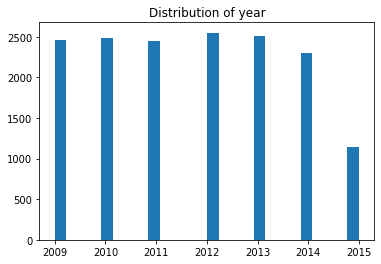

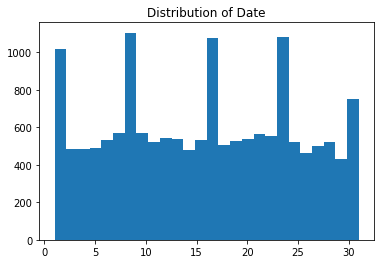

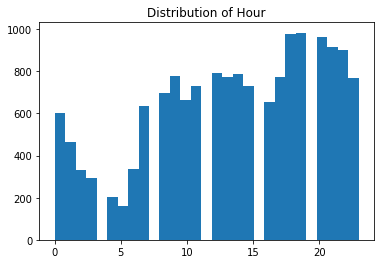

In [33]:
#For continuous variables
for i in cont_var[:4]:
    plt.hist(cab_train[i].dropna(),bins = 'auto')
    plt.title("Distribution of " + str(i))
    plt.show()

C:\Users\abhis\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\abhis\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


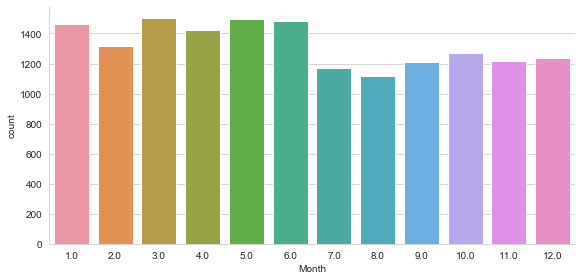

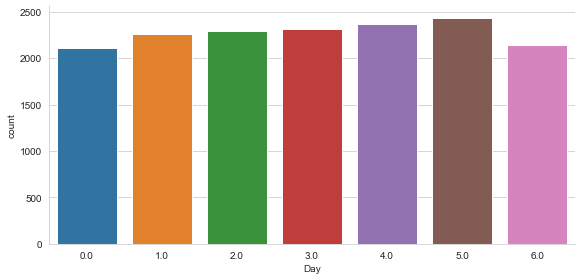

In [34]:
#Check the distribution of the Categorical variables
sns.set_style("whitegrid")
sns.factorplot(data=cab_data, x='Month', kind= 'count',size=4,aspect=2)
sns.factorplot(data=cab_data, x='Day', kind= 'count',size=4,aspect=2)

From the above plots, we can have a few quick insights.
* Demand of cabs is high on 6th and 5th days in a week and least on 1st day of the week
* Demand of cabs is high in the month of May, March and June respectively and least demand in August
* Cabs are high in demand during evening hours and least demand during early hours of the day
* Single travelled passenger's prefer cabs than with a group of 4/5    

Text(0, 0.5, 'Fare Amount')

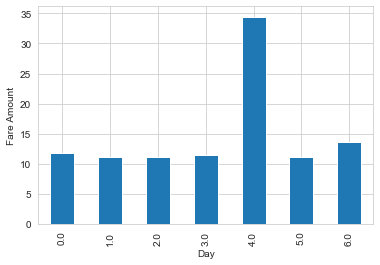

In [35]:
# Grouping the data using Day against our target variable and plotting bar plot
cab_data.groupby('Day').mean()['fare_amount'].plot.bar()
plt.ylabel('Fare Amount')

Text(0, 0.5, 'Fare Amount')

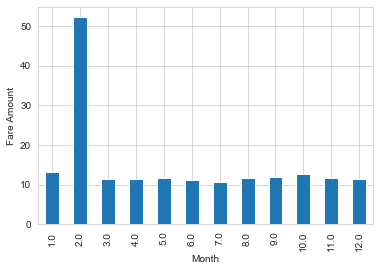

In [36]:
# Grouping the data using Month against our target variable and plotting bar plot
cab_data.groupby('Month').mean()['fare_amount'].plot.bar()
plt.ylabel('Fare Amount')

Text(0, 0.5, 'Fare Amount')

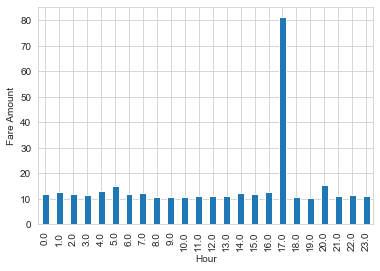

In [37]:
# Grouping the data using Hour against our target variable and plotting bar plot
cab_data.groupby('Hour').mean()['fare_amount'].plot.bar()
plt.ylabel('Fare Amount')

Text(0, 0.5, 'Fare Amount')

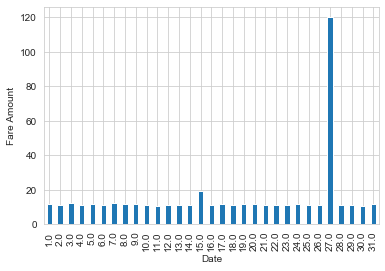

In [38]:
# Grouping the data using Date against our target variable and plotting bar plot
cab_data.groupby('Date').mean()['fare_amount'].plot.bar()
plt.ylabel('Fare Amount')

From the above plots, we can have a few quick insights.
* The average fare amount is higher on the 5th day of the week
* The average fare amount is higher in the month of February
* Fair amounts are higher between 6 P.M.- 7 P.M. and least at5 A.M.
* Average fare price is highest on 27th of every month
* The average fare amount is higher at 5 P.M.

## Feature Scaling
Let's scale our variables distance_travelled and passenger_count in both train and test datasets

In [39]:
#The data is right skewed in distance_travelled and hence we'll apply log on that variable
cab_data['distance_travelled'] = np.log1p(cab_data['distance_travelled'])
#To apply normalisation on passenger count
norm_var = ['passenger_count']

for i in norm_var:
    cab_data[i] = (cab_data[i] - cab_data[i].min()) / (cab_data[i].max() - cab_data[i].min())#Normalization formula

#To apply normalisation on passenger count for Test dataset
cab_test['distance_travelled'] = np.log1p(cab_test['distance_travelled'])
for i in norm_var:
    cab_test[i] = (cab_test[i] - cab_test[i].min()) / (cab_test[i].max() - cab_test[i].min())#Normalization formula


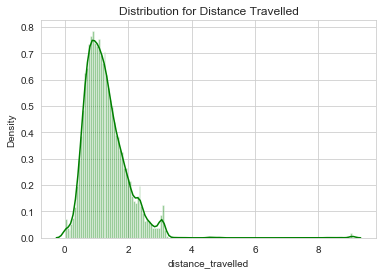

In [40]:
#Distribution of distance_travelled
sns.distplot(cab_data['distance_travelled'],bins='auto',color='green')
plt.title("Distribution for Distance Travelled")
plt.ylabel("Density")
plt.show()

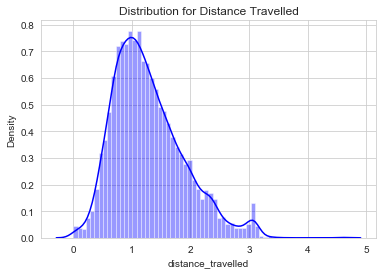

In [41]:
#To check the distribution of distance_travelled in the test data
sns.distplot(cab_test['distance_travelled'],bins='auto',color='blue')
plt.title("Distribution for Distance Travelled")
plt.ylabel("Density")
plt.show()

In [42]:
#To know the shapes of the train and test data
print(cab_data.shape)
print(cab_test.shape)

(15905, 8)
(9914, 7)


## Outlier Analysis
Outliers are to be detected by using box plot and those values are to be replaced or imputed by using various techniques such as mean, median or KNN method.

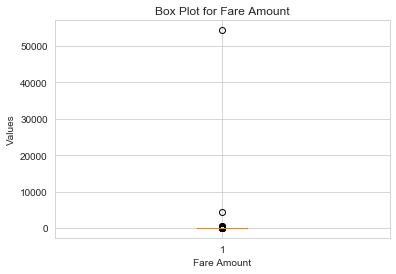

In [43]:
#Box plot for Fare Amount
plt.boxplot(cab_data['fare_amount'])
plt.xlabel("Fare Amount")
plt.ylabel("Values")
plt.title("Box Plot for Fare Amount")
plt.show()

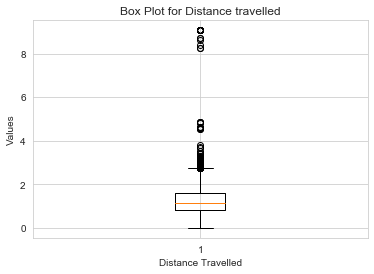

In [44]:
#Box plot for Fare Amount
plt.boxplot(cab_data['distance_travelled'])
plt.xlabel("Distance Travelled")
plt.ylabel("Values")
plt.title("Box Plot for Distance travelled")
plt.show()

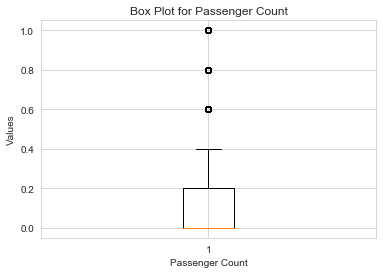

In [45]:
#Box plot for Fare Amount
plt.boxplot(cab_data['passenger_count'])
plt.xlabel("Passenger Count")
plt.ylabel("Values")
plt.title("Box Plot for Passenger Count")
plt.show()

It is found that we have a few outliers in passenger_count, fare_amount and distance_travelled

In [46]:
#List with variables with outliers
outliers = ['passenger_count', 'distance_travelled', 'fare_amount']

#Loop through the above list of variables
for i in outliers:
    q75,q25 = np.percentile(cab_data[i], [75,25]) #To get 75 and 25 percentile values
    iqr = q75 - q25 #Interquartile region
    #Calculating outerfence and innerfence
    outer = q75 + (iqr*1.5)
    inner = q25 - (iqr*1.5)
# Replacing all the outliers value to NA
cab_data.loc[cab_data[i]< inner,i] = np.nan
cab_data.loc[cab_data[i]> outer,i] = np.nan

In [47]:
# Imputing missing values with KNN
cab_data = pd.DataFrame(KNN(k = 3).fit_transform(cab_data), columns = cab_data.columns)
# Checking if there is any missing value
cab_data.isnull().sum().sum()

Imputing row 1/15905 with 0 missing, elapsed time: 77.164
Imputing row 101/15905 with 0 missing, elapsed time: 77.167
Imputing row 201/15905 with 0 missing, elapsed time: 77.170
Imputing row 301/15905 with 0 missing, elapsed time: 77.173
Imputing row 401/15905 with 1 missing, elapsed time: 77.176
Imputing row 501/15905 with 0 missing, elapsed time: 77.180
Imputing row 601/15905 with 0 missing, elapsed time: 77.184
Imputing row 701/15905 with 0 missing, elapsed time: 77.188
Imputing row 801/15905 with 0 missing, elapsed time: 77.192
Imputing row 901/15905 with 0 missing, elapsed time: 77.194
Imputing row 1001/15905 with 0 missing, elapsed time: 77.198
Imputing row 1101/15905 with 1 missing, elapsed time: 77.201
Imputing row 1201/15905 with 0 missing, elapsed time: 77.204
Imputing row 1301/15905 with 1 missing, elapsed time: 77.207
Imputing row 1401/15905 with 0 missing, elapsed time: 77.210
Imputing row 1501/15905 with 0 missing, elapsed time: 77.213
Imputing row 1601/15905 with 0 missi

0

In [48]:
#To ensure if the outliers are removed
cab_data.describe()
cab_data.shape

(15905, 8)

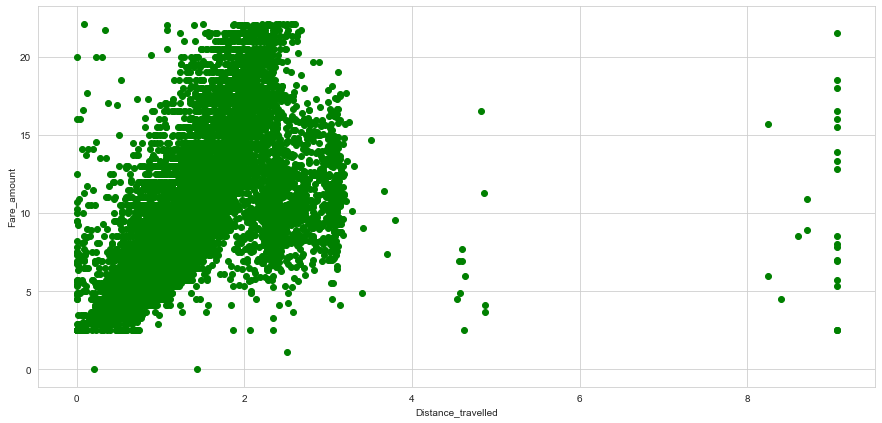

In [49]:
#Relationship between distance_travelled and fare_amount 
plt.figure(figsize=(15,7))
plt.scatter(x = cab_data['distance_travelled'],y = cab_data['fare_amount'],c = "g")
plt.xlabel('Distance_travelled')
plt.ylabel('Fare_amount')
plt.show()

Now `cab_data` is free from missing values, outliers with shape as (15905, 8). Let's proceed for Feature Selection, Feature Scaling and developing ML alogorithms on our training dataset.

## Feature Selection
To check for the multicollinearity for continuous variables by plotting correlation plot and remove the
variables with r > 0.8

[Text(0.5, 0, 'passenger_count'),
 Text(1.5, 0, 'year'),
 Text(2.5, 0, 'Date'),
 Text(3.5, 0, 'Hour'),
 Text(4.5, 0, 'fare_amount'),
 Text(5.5, 0, 'distance_travelled')]

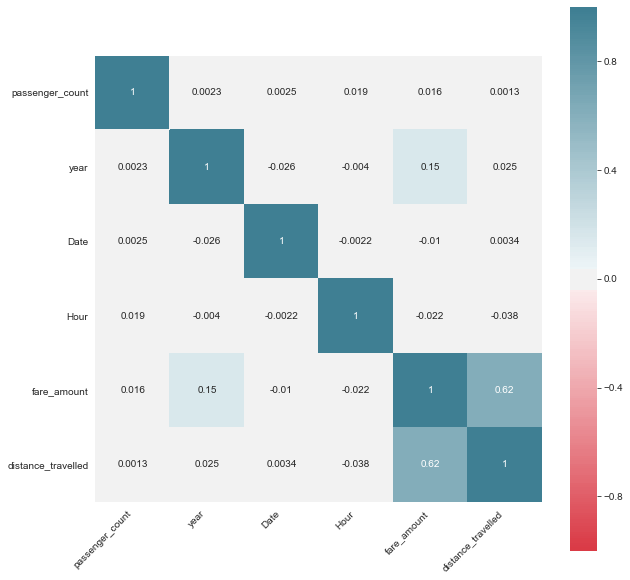

In [50]:
#Correlation analysis for continuous variables
#Let's store all the numeric data into an object
numeric_data = cab_data.loc[:,cont_var]
#Set the measurements of the plot, let's say width = 10 and height = 10
a , k = plt.subplots(figsize=(10,10))
#Correlation matrix
corr_matrix = numeric_data.corr()
#Plotting a correlation graph
ax = sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(10, 220, n=200),
square=True, annot = True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='right')

In [51]:
#Let's create dummy variables for categorical variables
#Get dummy variables for categorical variables
cab_data = pd.get_dummies(cab_data, columns = cat_var)
cab_test = pd.get_dummies(cab_test, columns = cat_var)
print(cab_data.shape)
print(cab_test.shape)

(15905, 25)
(9914, 24)


## Model development
We've performed all the Preprocessing techniques for our data. Our next step is to divide the data into train
and test, build a model upon the train data and evaluate on the test data. Then finally choose one ML model to validate on our actual test data and predict the values of `fare_amount`

In [52]:
#Splitting into train and test data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(cab_data.iloc[:,cab_data.columns != 'fare_amount'],
cab_data.iloc[:, 0], test_size = 0.20, random_state = 1)

In [53]:
#Building the model using linear regression
#Importing the necessary libraries for Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#Build a model on our training dataset
lr_model = LinearRegression().fit(X_train,y_train)
#Predict for the test cases
lr_predictions = lr_model.predict(X_test)
#To create a dataframe for both actual and predicted values
cabdata_lrmodel = pd.DataFrame({"Actual" : y_test, "Predicted" : lr_predictions})

#Function to find RMSE
def RMSE(x,y):
    rmse = np.sqrt(mean_squared_error(x,y))
    return rmse

#Function to find MAPE
def MAPE(true,predict):
    mape = np.mean(np.abs((true - predict) / true)) * 100
    return mape

#Calculate RMSE, MAPE and R-Squared value for this model

print("Root Mean Squared error :- " + str(RMSE(y_test,lr_predictions)))
print("R-Squared value :- " + str(r2_score(y_test,lr_predictions)))
print("Mean Absolute Percentage Error :- " + str(MAPE(y_test,lr_predictions)))

Root Mean Squared error :- 3.2439912807373465
R-Squared value :- 0.3646367994234325
Mean Absolute Percentage Error :- 26.610288661061137


In [54]:
#Building the model using Decisison Tree
#Importing necessary libraries for Decision tree
from sklearn.tree import DecisionTreeRegressor
#Build Decision tree model on the train data
dt_model = DecisionTreeRegressor(max_depth = 2).fit(X_train,y_train)
#Predict for the test cases
dt_predict = dt_model.predict(X_test)
#Create a dataframe for actual and predicted values
df_dtmodel = pd.DataFrame({"Actual" : y_test, "Predicted" : dt_predict})
#Calculate RMSE, MAPE and R_squared value for this model

print("RMSE: " + str(RMSE(y_test,dt_predict)))
print("R_Square score: " + str(r2_score(y_test,dt_predict)))
print("Mean Absolute Percentage Error :- " + str(MAPE(y_test,dt_predict)))

RMSE: 2.630702513439224
R_Square score: 0.5821636871780009
Mean Absolute Percentage Error :- 23.164666577472058


In [55]:
#Building the model using Randomforest
#Import library for RandomForest
from sklearn.ensemble import RandomForestRegressor
#Build random forest using RandomForestRegressor
ranfor_model = RandomForestRegressor(n_estimators = 300, random_state = 1).fit(X_train,y_train)
#Perdict for test cases
rf_predictions = ranfor_model.predict(X_test)
#Create data frame for actual and predicted values
df_rf = pd.DataFrame({'Actual': y_test, 'Predicted': rf_predictions})
#Calculate RMSE and R-squared value
print("Root Mean Squared Error: "+str(RMSE(y_test, rf_predictions)))
print("R_square Score: "+str(r2_score(y_test, rf_predictions)))
print("Mean Absolute Percentage Error :- " + str(MAPE(y_test,rf_predictions)))

Root Mean Squared Error: 2.3478613526491965
R_square Score: 0.6671813955736665
Mean Absolute Percentage Error :- 19.23515165255917


In [56]:
#Building the model using GradientBoosting
#Import necessary libraries for this ML algorithm
from sklearn.ensemble import GradientBoostingRegressor
#Build GB model on the train data
gb_model = GradientBoostingRegressor().fit(X_train,y_train)
#Predict the test cases
gb_predict = gb_model.predict(X_test)
#Create a dataframe for actual and predicted values
df_gbmodel = pd.DataFrame({"Actual" : y_test, "Predicted" : gb_predict})
#Calculate RMSE and R_squared values
print("RMSE: " + str(RMSE(y_test,dt_predict)))
print("R_Square score: " + str(r2_score(y_test,gb_predict)))
print("Mean Absolute Percentage Error :- " + str(MAPE(y_test,gb_predict)))

RMSE: 2.630702513439224
R_Square score: 0.6812319510750917
Mean Absolute Percentage Error :- 18.700421380160815


## Dimension Reduction using Pricipal Component Analysis
Principal Component Analysis (PCA) is a dimension-reduction tool that can be used to reduce a large set of
variables to a small set that still contains most of the information in the large set.

In [57]:
#Get the target variable
target_var = cab_data['fare_amount']
#Get the shape of our cleaned dataset
cab_data.shape #(15451, 25)
#Importing the library for PCA
from sklearn.decomposition import PCA
#Dropping the target variable
cab_data.drop(['fare_amount'], inplace = True, axis =1)
#To check the shape of the data after dropping the target variable
cab_data.shape# (15451, 25)

(15905, 24)

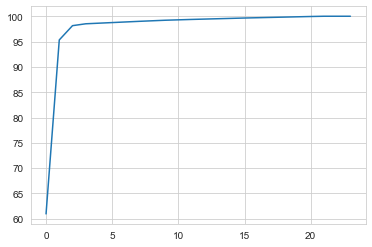

In [58]:
#Converting our data to numpy array
numpy_data = cab_data.values
#Our data without target variable has 133 variables, so number of components = 24
pca = PCA(n_components = 24)
pca.fit(numpy_data)
#To check the variance that each PC explains
var = pca.explained_variance_ratio_
#Cumulative variance
var_cum = np.cumsum(np.round(var, decimals = 4) * 100)
plt.plot(var_cum)
plt.show()

From the above graph, it is clear that approximately after 7 components, there is no variance even if all the rest
of the components are considered. So let's select these 7 components as it explains almost 95 percent of data
variance.

In [59]:
#Selecting the 7 components
pca = PCA(n_components = 7)
#To fit the selected components to the data
pca.fit(numpy_data)
#Splitting into train and test data using train_test_split
X_train1,X_test1,y_train1,y_test1 = train_test_split(numpy_data,target_var,test_size = 0.2)

Now by using the above data let's develop the model on our train data

In [60]:
#Building the model using linear regression
#Importing the necessary libraries for Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#Build a model on our training dataset
lr_model = LinearRegression().fit(X_train1,y_train1)
#Predict for the test cases
lr_predictions = lr_model.predict(X_test1)
#To create a dataframe for both actual and predicted values
cabdata_lrmodel = pd.DataFrame({"Actual" : y_test1, "Predicted" : lr_predictions})

#Function to find RMSE
def RMSE(x,y):
    rmse = np.sqrt(mean_squared_error(x,y))
    return rmse

#Function to find MAPE
def MAPE(true,predict):
    mape = np.mean(np.abs((true - predict) / true)) * 100
    return mape

#Calculate RMSE, MAPE and R-Squared value for this model

print("Root Mean Squared error :- " + str(RMSE(y_test1,lr_predictions)))
print("R-Squared score :- " + str(r2_score(y_test1,lr_predictions)))
print("Mean Absolute Percentage Error :- " + str(MAPE(y_test1,lr_predictions)))

Root Mean Squared error :- 3.181328125797752
R-Squared score :- 0.38830975176005045
Mean Absolute Percentage Error :- inf


In [61]:
#Building the model using Decisison Tree
#Importing necessary libraries for Decision tree
from sklearn.tree import DecisionTreeRegressor
#Build Decision tree model on the train data
dt_model = DecisionTreeRegressor(max_depth = 2).fit(X_train1,y_train1)
#Predict for the test cases
dt_predict = dt_model.predict(X_test1)
#Create a dataframe for actual and predicted values
df_dtmodel = pd.DataFrame({"Actual" : y_test1, "Predicted" : dt_predict})
#Calculate RMSE, MAPE and R_squared value for this model

print("RMSE: " + str(RMSE(y_test1,dt_predict)))
print("R_Square score: " + str(r2_score(y_test1,dt_predict)))
print("Mean Absolute Percentage Error :- " + str(MAPE(y_test1,dt_predict)))

RMSE: 2.6366641934454624
R_Square score: 0.5798307460004233
Mean Absolute Percentage Error :- inf


In [62]:
#Building the model using Randomforest
#Import library for RandomForest
from sklearn.ensemble import RandomForestRegressor
#Build random forest using RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators = 300, random_state = 1).fit(X_train1,y_train1)
#Perdict for test cases
rf_predictions = rf_model.predict(X_test1)
#Create data frame for actual and predicted values
df_rf = pd.DataFrame({'Actual': y_test1, 'Predicted': rf_predictions})
#Calculate RMSE and R-squared value
print("Root Mean Squared Error: "+str(RMSE(y_test1, rf_predictions)))
print("R_square Score: "+str(r2_score(y_test1, rf_predictions)))
print("Mean Absolute Percentage Error :- " + str(MAPE(y_test1,rf_predictions)))

Root Mean Squared Error: 2.3083096540441312
R_square Score: 0.6779652316471204
Mean Absolute Percentage Error :- inf


In [63]:
#Building the model using GradientBoosting
#Import necessary libraries for this ML algorithm
from sklearn.ensemble import GradientBoostingRegressor
#Build GB model on the train data
gb_model = GradientBoostingRegressor().fit(X_train1,y_train1)
#Predict the test cases
gb_predict = gb_model.predict(X_test1)
#Create a dataframe for actual and predicted values
df_gbmodel = pd.DataFrame({"Actual" : y_test1, "Predicted" : gb_predict})
#Calculate RMSE and R_squared values
print("RMSE: " + str(RMSE(y_test1,dt_predict)))
print("R_Square score: " + str(r2_score(y_test1,gb_predict)))
print("Mean Absolute Percentage Error :- " + str(MAPE(y_test1,gb_predict)))

RMSE: 2.6366641934454624
R_Square score: 0.6898300778943877
Mean Absolute Percentage Error :- inf


So we have finally decided that RandomForest has predicted the least RMSE indicating the best fit. So let's predict our cleaned test data using Randomforest Regressor.

In [64]:
#Building the model using Randomforest
#Import library for RandomForest
from sklearn.ensemble import RandomForestRegressor
#Build random forest using RandomForestRegressor
rf_predictions_test = rf_model.predict(cab_test)
#Create a new variable to the test dataset
cab_test['Predicted_Fare'] = rf_predictions_test

In [65]:
cab_test.head()

,passenger_count,year,Date,Hour,distance_travelled,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_5.0,...,Month_11.0,Month_12.0,Day_0.0,Day_1.0,Day_2.0,Day_3.0,Day_4.0,Day_5.0,Day_6.0,Predicted_Fare
0,0.0,2015.0,27.0,13.0,1.200263,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,11.641667
1,0.0,2015.0,27.0,13.0,1.230751,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,11.656333
2,0.0,2011.0,8.0,11.0,0.481303,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4.387864
3,0.0,2012.0,1.0,21.0,1.085078,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,8.589667
4,0.0,2012.0,1.0,21.0,1.853612,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,16.316506


In [66]:
cab_test.isna().sum()

passenger_count       0
year                  0
Date                  0
Hour                  0
distance_travelled    0
Month_1.0             0
Month_2.0             0
Month_3.0             0
Month_4.0             0
Month_5.0             0
Month_6.0             0
Month_7.0             0
Month_8.0             0
Month_9.0             0
Month_10.0            0
Month_11.0            0
Month_12.0            0
Day_0.0               0
Day_1.0               0
Day_2.0               0
Day_3.0               0
Day_4.0               0
Day_5.0               0
Day_6.0               0
Predicted_Fare        0
dtype: int64

In [67]:
cab_test.to_csv("Predicted_testdata.csv")